# Summary of Data

Let's start by loading the data.

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from bestreads.dataset import convert_str_array
from bestreads.dataset import download_dataset

In [2]:
download_dataset()
data = pd.read_csv('./data/goodreads_books.csv')
data.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


## Book Recommendations

Now that we have read the data in properly, let's explore some of the values.  For example, we can see that there is a column where Goodreads recommends similar books.  Let's see what the distribution of the number of recommendations looks like!  First, we will need to write a function that can parse the book ID's into a list.

/home/adam/Documents/bestreads/bestreads/dataset.py:111: RuntimeWarning: NaN value detected in convert_str_array(string)
  category=RuntimeWarning)


Text(0, 0.5, 'Frequency')

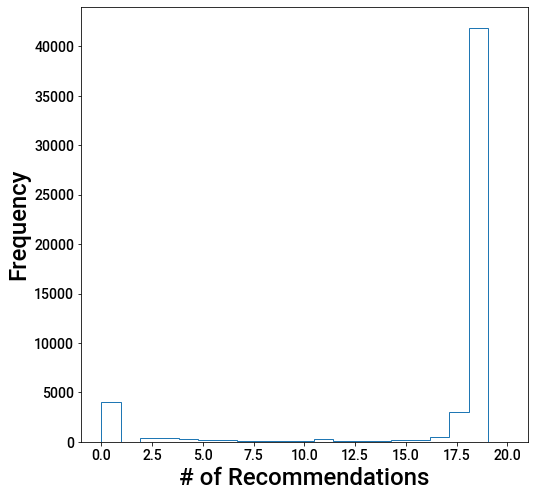

In [3]:
book_recommendations = []
for book_rec in data.recommended_books:
    book_recommendations.append(len(convert_str_array(book_rec)))

fig = plt.figure(figsize=(8, 8))
sp = fig.add_subplot(111)
sp.hist(book_recommendations, histtype='step', range=(0, 20), bins=(21))
sp.set_xlabel('# of Recommendations')
sp.set_ylabel('Frequency')

It appears that almost all of the books have exactly 18 book recommendations, with a small number containing fewer or zero.  This may be due to the fact that this isn't a comprehensive dataset and book ID's for books outside of the dataset are not included.  We could verify this by checking to see if every recommended book has a corresponding ID in the dataset:

In [4]:
book_rec_ids = set()
for book_rec in data.recommended_books:
    book_rec_ids.update(convert_str_array(book_rec))
    
rec_not_in_data = set()
for this_id in book_rec_ids:
    if this_id not in data.id.values:
        rec_not_in_data.add(this_id)

print(f'{len(rec_not_in_data)} of {len(book_rec_ids)} '
      + f'({100.*len(rec_not_in_data)/len(book_rec_ids):.2f}%) recommended books aren\'t in our dataset.')

/home/adam/Documents/bestreads/bestreads/dataset.py:111: RuntimeWarning: NaN value detected in convert_str_array(string)
  category=RuntimeWarning)


206166 of 236274 (87.26%) recommended books aren't in our dataset.


It seems that this dataset does, in fact, contain references to books that are not in the dataset.  Further, because the overwhelming majority of the recommended books aren't in our dataset, we can assume that ours is a relatively small sample (if that wasn't already abundantly clear).

## Book Series

We can perform a similar exploratory analysis on the books in series to see how likely a book is to be in a series, what the typical series length is, and how good our dataset is at keeping all or most books in the same series.

To start with, we can see how long the typical series is by counting the elements in each list without repetition:

In [5]:
# Note that one element in our series set is going to be empty because of NaN values
# for books that have no series
set_of_series = set(frozenset(convert_str_array(series_ids)) for series_ids in data.books_in_series)

all_serial_ids = set()
serial_not_in_data = set()
for this_series in set_of_series:
    all_serial_ids.update(this_series)
    for this_id in this_series:
        if this_id not in data.id.values:
            serial_not_in_data.add(this_id)
            
print(f'{len(serial_not_in_data)} of {len(all_serial_ids)} '
      + f'({100.*len(serial_not_in_data)/len(book_rec_ids):.2f}%) serial books aren\'t in our dataset.')

29827 of 42706 (12.62%) serial books aren't in our dataset.


Thus we find that an identical portion of our serial books are also outside of the sample.  Now, we can see how long the average series is by taking the length of each element of `set_of_series`:

Text(0, 0.5, 'Frequency')

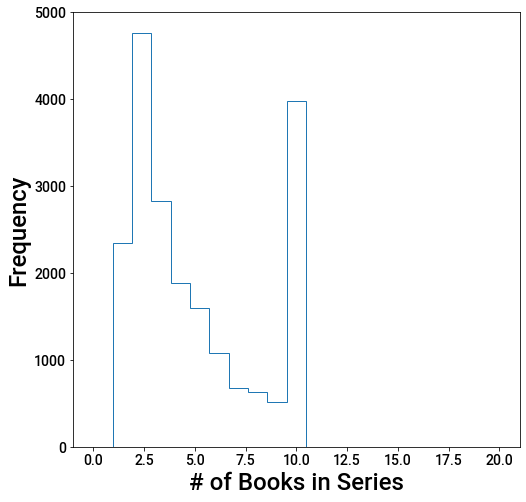

In [6]:
series_lengths = [len(this_series) for this_series in set_of_series]

fig = plt.figure(figsize=(8, 8))
sp = fig.add_subplot(111)
sp.hist(series_lengths, histtype='step', range=(0, 20), bins=(21))
sp.set_xlabel('# of Books in Series')
sp.set_ylabel('Frequency')

Interestingly enough, we see that most series are approximately 2 books long or exactly 10 books long.  It would be a good idea to verify that the hard cutoff at 10 books isn't an artificial feature introduced by a limit in the string length of our dataset or similar.

Addditionally, it can be seen that many books are in a series of size 1.  It may be that these are new series in the making where only the first book has been released so far.  It should not include books that are not in a series entirely, as they will have NaN values in the `books_in_series` column rather than a single value.

Finally, we can examine what fraction of our books are not in series:

In [7]:
not_in_series = data.books_in_series.isnull()

print(f'{sum(not_in_series)} of {len(not_in_series)} '
      + f'({100.*sum(not_in_series)/len(not_in_series):.2f}%) books in this dataset aren\'t in series.')

30121 of 52199 (57.70%) books in this dataset aren't in series.


## A Few Final Stats

We can round out the summary of our data by counting the number of valid entries in each column:

In [8]:
print(data.apply(lambda x: 
                 pd.Series([
                     x.isnull().sum(),
                     x.isnull().sum()/float(len(x))]
                    , index=['NaNs', 'frac_NaNs']
                          )).transpose()
                            .astype({'NaNs':'int', 'frac_NaNs':'float'}))

                         NaNs  frac_NaNs
id                          0   0.000000
title                       0   0.000000
link                        0   0.000000
series                  28880   0.553267
cover_link                607   0.011629
author                      0   0.000000
author_link                 0   0.000000
rating_count                0   0.000000
review_count                0   0.000000
average_rating              0   0.000000
five_star_ratings           0   0.000000
four_star_ratings           0   0.000000
three_star_ratings          0   0.000000
two_star_ratings            0   0.000000
one_star_ratings            0   0.000000
number_of_pages          2330   0.044637
date_published            860   0.016475
publisher                3636   0.069657
original_title          12949   0.248070
genre_and_votes          2840   0.054407
isbn                    11883   0.227648
isbn13                  12692   0.243146
asin                    46963   0.899692
settings        

Note that the number of NaNs in the `series` column is different from the number of NaNs in the `books_in_series` column.  This could be that some elements of a series may not be on Goodreads entirely and therefore lack an ID to put in `books_in_series`.

## Null Value Covariance

We can calculate the overlap in null values between columns to visualize which columns will be most effective if we purge null values.

/home/adam/miniconda3/envs/Research/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


Text(0, 0.5, 'That are Also In This Column')

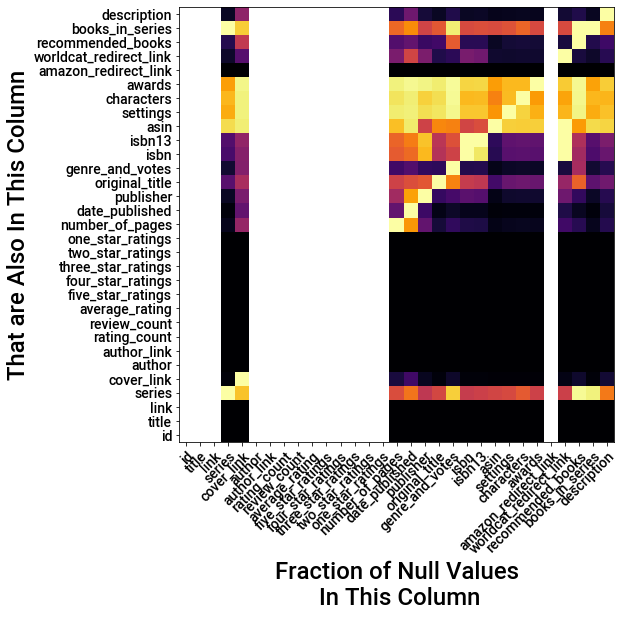

In [9]:
# cov holds fraction of null values in column <column> that also
# occur in column <index>
cov = pd.DataFrame([], columns=data.columns, index=data.columns)
for col_x in data.columns:
    for col_y in data.columns:
        both_null = (data[col_x].isnull() & data[col_y].isnull()).sum()
        cov[col_x][col_y] = both_null/data[col_x].isnull().sum()

fig = plt.figure(figsize=(8,8))
sp = fig.add_subplot(111)

sp.imshow(cov.values.astype(float), origin='lower', cmap='inferno')
sp.set_yticks(range(len(cov.columns)))
sp.set_xticks(range(len(cov.columns)))
sp.set_yticklabels(cov.columns)
sp.set_xticklabels(cov.columns)
plt.setp(sp.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sp.set_xlabel('Fraction of Null Values\n In This Column')
sp.set_ylabel('That are Also In This Column')

Note that columns with no null values render as columns of blank pixels in the plot because dividing by the number of null values (zero) gives a NaN.

It seems that a large fraction of null values in the `awards`, `characters`, `settings`, `asin`, `series`, and `books_in_series` columns share their null values with other columns.  As a result, getting rid of rows that included nan values for one or more of those columns would at least also eliminate nan values in other columns as well.